## **1. Загрузить любой набор данных с https://www.kaggle.com, подходящий к задачам классификации и регрессии (либо два набора - отдельно для каждой из задач).**

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('diabetes_prediction_dataset.csv')[:2000]
df['gender'].replace(['Female','Male', 'Other'],[0,1, np.nan],inplace=True)
df.drop(columns=['smoking_history'],inplace=True)
df.dropna(inplace=True)
vMin = df.min( axis = 0 )
x = (df - vMin) / (df.max( axis = 0 ) - vMin)

## **2. Выполнить подбор параметров модели классификатора и регрессора (по выбору) с использованием GridSearchCV:**

In [2]:
#1. Выбрать какую-нибудь модель классификатора (KNeighborsClassifier, DecisionTreeClassifier, Наивный Байес, LogisticRegression...):
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

X =  np.array( x.iloc[:,:-1] )#.reshape(-1,11)
Y =  np.array( x.iloc[:,-1] )

dtc = DecisionTreeClassifier()

#    1.1. Выбрать совокупность настраиваемых параметров и диапазоны их значений
params = { 'max_depth': range (2, 20, 1),
              'min_samples_leaf': range (1, 10),
              'min_samples_split': range (2,10,2) }

#    1.2. Реализовать поиск наилучших параметров с использованием GridSearchCV
grid = GridSearchCV(dtc, params, cv = 5, n_jobs = -1)
grid.fit(X, Y)
#    1.3. Вывести наилучшие найденные значения параметров и соответствующую метрику качества классификации
print(f"Наилучшие значения параметров: {grid.best_params_}")
print(f"Наилучшее значение метрики: {grid.best_score_}")

Наилучшие значения параметров: {'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}
Наилучшее значение метрики: 0.9710000000000001


In [3]:
#2. Выбрать какую-нибудь модель регрессора (KNeighborsRegressor, DecisionTreeRegressor, LinearReegresion, ...):
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()

#    2.1. Выбрать совокупность настраиваемых параметров и диапазоны их значений
params = { 'max_depth': range (2, 20, 1),
              'min_samples_leaf': range (1, 10),
              'min_samples_split': range (2,10,2) }

#    2.2. Реализовать поиск наилучших параметров с использованием GridSearchCV
grid = GridSearchCV(dtr, params, cv = 5, n_jobs = -1)
grid.fit(X, Y)
#    2.3. Вывести наилучшие найденные значения параметров и соответствующую метрику качества классификации
print(f"Наилучшие значения параметров: {grid.best_params_}")
print(f"Наилучшее значение метрики: {grid.best_score_}")

Наилучшие значения параметров: {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Наилучшее значение метрики: 0.6661628801450742


## **3. Решить задачу классификации с использованием случайного леса (RandomForestClassifier):**

In [4]:
#1. С помощью GridSearchCV подобрать наилучшие параметры случайного леса для задачи классификации 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

X_train, X_test, y_train, y_test = train_test_split(X[:100], Y[:100], train_size = 0.75)

forest = RandomForestClassifier(n_estimators = 5)
forest.fit(X_train, y_train)

print("Точность на обучающем наборе: {:.3f}".format(forest.score(X_train, y_train)))
print("Точность на тестовом наборе: {:.3f}".format(forest.score(X_test, y_test)))


Точность на обучающем наборе: 1.000
Точность на тестовом наборе: 0.840


In [5]:
params = {  "n_estimators": range(3,20),
            'max_depth': range (2, 20, 1),
            'min_samples_leaf': range (1, 10),
            'min_samples_split': range (2,10,2) }

gridRf = GridSearchCV(forest, params, cv = 5, n_jobs = -1)
gridRf.fit(X_train, y_train)

print(f"Наилучшие значения параметров: {gridRf.best_params_}")
print(f"Наилучшее значение метрики: {gridRf.best_score_}")

Наилучшие значения параметров: {'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 3}
Наилучшее значение метрики: 0.96


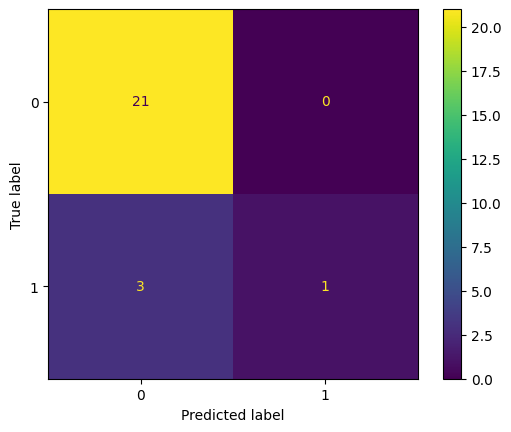

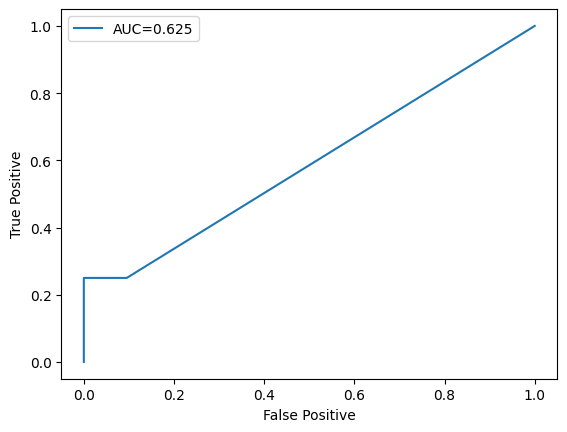

In [6]:
#2. С полученными параметрами вычислить метрики качества классификации (Confusion Matrix, ROC + AUC)
import matplotlib.pyplot as plt
y_test_predict = gridRf.predict(X_test)
y_test_prob = gridRf.predict_proba(X_test)[:,1]

confMatr = confusion_matrix(y_test, y_test_predict)
cmPlt = ConfusionMatrixDisplay(confusion_matrix = confMatr)
cmPlt.plot()
plt.show()

auc = roc_auc_score( y_test, y_test_predict )
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
plt.plot(fpr, tpr, label = "AUC=" + str(auc))
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.legend()
plt.show()

## **4. Реализовать ансамбли моделей для задачи классификации и регрессии**

In [7]:
#1. Реализовать бэггинг BaggingClassifier на базе любой модели классификации
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# разделяем данные на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2 )

# создаем базовый алгоритм KNeighborsClassifier
base_model = KNeighborsClassifier()

# создаем ансамбль на основе базового алгоритма с использованием бэггинга
bagging_model = BaggingClassifier( estimator = base_model, n_estimators = 10, random_state = 42 )

# обучаем модель на обучающих данных
bagging_model.fit( X_train, y_train )

# делаем предсказания на тестовых данных
y_pred = bagging_model.predict( X_test )

In [8]:
# Вычислите метрики качества модели
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Выведите метрики качества модели
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9575
Precision: 0.9565217391304348
Recall: 0.5789473684210527
F1 Score: 0.721311475409836


In [9]:
#2. Реализовать бэггинг для задачи регрессии BaggingRegressor для любой модели регрессии
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# разделяем данные на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2 )

bagging_model = BaggingRegressor(estimator=base_model, n_estimators=5)

# обучаем модель на обучающих данных
bagging_model.fit( X_train, y_train )

# делаем предсказания на тестовых данных
y_pred = bagging_model.predict( X_test )

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Вычислите метрики качества модели
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Выведите метрики качества модели
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Coefficient of Determination (R^2):", r2)

Mean Squared Error (MSE): 0.04710000000000001
Mean Absolute Error (MAE): 0.0625
Coefficient of Determination (R^2): 0.5457778313543487


In [11]:
#3. Реализовать меод градиентного бустинга GradiendBoostingClassifier на базе любой модели классификации 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# разделяем данные на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2 )

# создаем базовый алгоритм DecisionTreeClassifier
base_model = DecisionTreeClassifier()

boosting_model = GradientBoostingClassifier(n_estimators = 10, random_state = 42  )

# обучаем модель на обучающих данных
boosting_model.fit( X_train, y_train )

# делаем предсказания на тестовых данных
y_pred = boosting_model.predict( X_test )

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#вычисляем метрики качества модели, такие как точность (accuracy), точность (precision), полноту (recall) и F1-меру (F1 score), чтобы оценить производительность модели.
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.985
Precision: 1.0
Recall: 0.7857142857142857
F1 Score: 0.88


In [13]:
#4. Реализовать меод градиентного бустинга GradiendBoostingRegressor на базе любой модели регрессии 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# разделяем данные на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.2 )

boosting_model = GradientBoostingRegressor(n_estimators=100)

# обучаем модель на обучающих данных
boosting_model.fit( X_train, y_train )

# делаем предсказания на тестовых данных
y_pred = boosting_model.predict( X_test )

In [14]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Выведите метрики качества модели
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Coefficient of Determination (R^2):", r2)

Mean Squared Error (MSE): 0.02419066609272379
Mean Absolute Error (MAE): 0.05404323861399711
Coefficient of Determination (R^2): 0.6889660418807613
